In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import torch
import splitfolders
import matplotlib.pyplot as plt
%matplotlib inline
import shutil

from PIL import Image
from ultralytics import YOLO

In [2]:
def rm_folder_if_exists(folder):
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
        except OSError as e:
            print("Error: %s - %s." % (e.filename, e.strerror))

In [3]:
def draw_yolo_labels(img, label_path, imgsz=1024):
    orig_h, orig_w = img.shape[:2]
    scale = min(imgsz / orig_w, imgsz / orig_h)
    resized_w, resized_h = int(orig_w * scale), int(orig_h * scale)
    pad_x = (imgsz - resized_w) // 2
    pad_y = (imgsz - resized_h) // 2

    with open(label_path, 'r') as f:
        for line in f:
            if not line.strip():
                continue
            cls, xc, yc, bw, bh = map(float, line.strip().split())

            x_center = xc * imgsz
            y_center = yc * imgsz
            box_w = bw * imgsz
            box_h = bh * imgsz

            x_center -= pad_x
            y_center -= pad_y

            x_center /= scale
            y_center /= scale
            box_w /= scale
            box_h /= scale

            x1 = int(x_center - box_w / 2)
            y1 = int(y_center - box_h / 2)
            x2 = int(x_center + box_w / 2)
            y2 = int(y_center + box_h / 2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return img

In [4]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(f"Setup complete. Using torch {torch.__version__} ({DEVICE})")

Setup complete. Using torch 2.6.0+cu124 (cuda:0)


In [4]:
splitfolders.ratio('./HumanDetection/heridal', output='./HumanDetection/heridal_split/images',
                seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 1546 files [00:04, 325.03 files/s]


In [5]:
TRAIN_DATA_DIR = './HumanDetection/heridal_split/images/train/class0'
VAL_DATA_DIR = './HumanDetection/heridal_split/images/val/class0'

IMG_WIDTH = 4000
IMG_HEIGHT = 3000

EPOCHS = 100

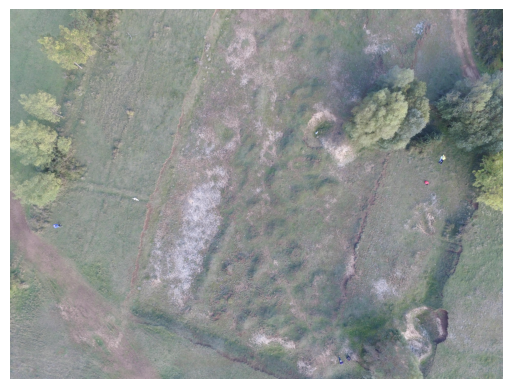

In [6]:
test_img = TRAIN_DATA_DIR + '/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.jpg' 

img = cv2.imread(test_img)
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [7]:
df = pd.read_csv('./HumanDetection/heridal/_annotations.csv')
df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,human,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,human,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,human,2578,1010,2658,1079


In [8]:
df = df.replace('human', 0)
df.head()

/tmp/ipykernel_521956/1064772545.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('human', 0)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,train_BRA_1012_JPG.rf.fa0e8bf1e58b462173e12dd6...,4000,3000,0,754,1012,791,1046
1,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1910,1258,1949,1294
2,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,966,1900,1016,1931
3,train_TRS_0011_JPG.rf.fa99c61ccfa4b048cafbafc0...,4000,3000,0,1564,2624,1604,2676
4,train_BRK_2092_JPG.rf.fc6ba9e5aa512819b66ef089...,4000,3000,0,2578,1010,2658,1079


In [9]:
print(df['class'].unique())
print(df['width'].unique())
print(df['height'].unique())

[0]
[4000]
[3000]


In [10]:
LABELS_DIR_TRAIN = './HumanDetection/heridal_split/labels/train/class0'
LABELS_DIR_VAL = './HumanDetection/heridal_split/labels/val/class0'
os.makedirs(LABELS_DIR_TRAIN, exist_ok=True)
os.makedirs(LABELS_DIR_VAL, exist_ok=True)

In [10]:
grouped = df.groupby('filename')

for filename, group in grouped:
    img_train = os.path.join(TRAIN_DATA_DIR, filename)

    if os.path.exists(img_train):
        txt_path = os.path.join(LABELS_DIR_TRAIN, os.path.splitext(filename)[0] + '.txt')
    else:
        txt_path = os.path.join(LABELS_DIR_VAL, os.path.splitext(filename)[0] + '.txt')

    with open(txt_path, 'w') as f:
        for _, row in group.iterrows():
            class_id = row['class']
            x_center = ((row['xmin'] + row['xmax']) / 2) / IMG_WIDTH
            y_center = ((row['ymin'] + row['ymax']) / 2) / IMG_HEIGHT
            width = (row['xmax'] - row['xmin']) / IMG_WIDTH
            height = (row['ymax'] - row['ymin']) / IMG_HEIGHT
            
            f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

In [13]:
with open('./HumanDetection/heridal_split/labels/train/class0/train_BLA_0002_JPG.rf.1e82cab69709e084d88eed66b0aa2a88.txt', 'r') as f:
    print(f.read())

0 0.096875 0.586167 0.018750 0.014333
0 0.670000 0.948667 0.012500 0.024667
0 0.876500 0.407833 0.014500 0.029667



In [14]:
rm_folder_if_exists('./runs/detect/yolo11s_heridal')

In [15]:
model = YOLO('yolo11s.pt')

results = model.train(
    # Common settings
    data='./HumanDetection/heridal.yaml',
    epochs=300,
    device=DEVICE,
    imgsz=1184,
    batch=10,
    single_cls=True,
    workers=2,
    # Optimizer, learning rate scheduling
    optimizer='AdamW',
    lr0=1e-3,
    lrf=1e-6,
    cos_lr=True,
    # Augmentation settings
    cutmix=0.3,
    hsv_v=0.6,
    hsv_s=0.5,
    hsv_h=0.005,
    # Result storing settings
    name='yolo11s_heridal',
    save=True,
    save_period=25,
    resume=False
)

New https://pypi.org/project/ultralytics/8.3.141 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=10, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.3, data=./HumanDetection/heridal.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.005, hsv_s=0.5, hsv_v=0.6, imgsz=1184, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=1e-06, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo11s_heridal, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.

train: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/train/class0.cache... 788 images, 448 backgrounds, 0 corrupt: 100%|██████████| 1236/1236 [00:00<?, ?


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 5001.5±3635.5 MB/s, size: 3501.9 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11s_heridal/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00046875), 87 bias(decay=0.0)
Image sizes 1184 train, 1184 val
Using 2 dataloader workers
Logging results to runs/detect/yolo11s_heridal
Starting training for 300 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/300      8.71G      2.035      8.827      1.086         14       1184: 100%|██████████| 124/124 [00:54<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.508      0.624      0.563      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/300       8.8G       1.94       1.46      1.021         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]


                   all        310        574      0.619      0.552      0.552      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/300      8.79G      1.903      1.418      1.029         19       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

                   all        310        574        0.7      0.668      0.684      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/300      8.78G      1.925      1.502       1.02         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


                   all        310        574       0.65       0.61       0.62      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/300      8.76G      1.859      1.334      1.011          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


                   all        310        574      0.672      0.655      0.693      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/300      8.77G      1.835      1.259      1.001         38       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.26it/s]


                   all        310        574       0.55      0.599      0.547       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/300      8.78G      1.869      1.331       1.01         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.20it/s]

                   all        310        574      0.651      0.533      0.584      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/300      8.82G      1.822      1.265      1.005         24       1184: 100%|██████████| 124/124 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574       0.74      0.674      0.738      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/300      8.77G      1.757       1.21     0.9925         21       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


                   all        310        574      0.608      0.629      0.623      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/300       8.8G      1.829      1.285      1.012         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]


                   all        310        574      0.639       0.62      0.629      0.307

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/300      8.81G      1.756      1.221      0.989         45       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


                   all        310        574       0.73      0.639      0.711      0.356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/300      8.83G      1.756      1.215     0.9836          6       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


                   all        310        574       0.76      0.691      0.745      0.392

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/300      8.82G      1.752      1.197     0.9743         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


                   all        310        574      0.725      0.641      0.707      0.361

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/300      8.81G       1.74      1.161     0.9746         14       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]


                   all        310        574      0.666      0.706      0.734      0.386

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/300      8.87G      1.735      1.135     0.9775         13       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]


                   all        310        574      0.772      0.688      0.767      0.388

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/300      8.78G      1.661      1.082     0.9562         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]


                   all        310        574      0.717      0.643      0.706      0.352

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/300      8.84G      1.679      1.108      0.975         27       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


                   all        310        574      0.717      0.667      0.726      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/300      8.81G      1.644       1.05     0.9565         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


                   all        310        574      0.689      0.597      0.681      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/300       8.8G      1.638       1.12     0.9582         14       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.793      0.725      0.792      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/300       8.8G      1.634      1.042     0.9461         15       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


                   all        310        574      0.687      0.643      0.687      0.342

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/300      8.79G      1.598      1.005       0.96         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


                   all        310        574      0.761      0.737      0.791      0.436

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/300      8.88G      1.663      1.096     0.9611         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]


                   all        310        574      0.766      0.716      0.783      0.405

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/300      8.82G      1.622      1.072     0.9484         40       1184: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]


                   all        310        574      0.718      0.666      0.729      0.375

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/300       8.8G      1.597      1.055     0.9439         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


                   all        310        574      0.777      0.733      0.792      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/300      8.81G      1.613      1.033     0.9526         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]

                   all        310        574      0.754      0.695      0.764      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/300      8.86G      1.578     0.9945     0.9334         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.763      0.711      0.779      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/300      8.83G      1.607      1.018     0.9448          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]


                   all        310        574      0.779      0.693      0.762      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/300      8.79G      1.598     0.9866     0.9339         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.822      0.742      0.806      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/300      8.76G      1.586          1     0.9332          5       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.706       0.66      0.718      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/300      8.78G      1.583     0.9875     0.9448         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]


                   all        310        574      0.766      0.735      0.777       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/300      8.78G      1.556      0.994     0.9279         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


                   all        310        574      0.771      0.695      0.789      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/300       8.8G      1.505     0.9259     0.9186         21       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.816      0.728        0.8      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/300      8.82G      1.522     0.9314     0.9265         22       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


                   all        310        574      0.775      0.695      0.765      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/300      8.79G      1.534     0.9297     0.9345         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


                   all        310        574      0.742      0.718      0.788      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/300      8.76G      1.544     0.9402     0.9283         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.724      0.693       0.74      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/300      8.83G      1.542     0.9083     0.9203         12       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.788      0.724      0.788      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/300      8.79G      1.542     0.9854     0.9281         22       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.751      0.726      0.774      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/300       8.8G      1.529     0.9247     0.9222          8       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.815      0.747      0.831      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/300      8.83G      1.535     0.9462     0.9238         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.799      0.711      0.811      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/300      8.87G      1.516     0.9157     0.9296         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]


                   all        310        574      0.722      0.716      0.762      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/300      8.86G      1.547     0.9437     0.9295         29       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.801      0.772      0.829       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/300      8.83G      1.512     0.9202     0.9231         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


                   all        310        574      0.795      0.744      0.798      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/300      8.78G      1.496     0.9297     0.9126          6       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]


                   all        310        574      0.794      0.744      0.825      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/300      8.81G      1.485      0.922     0.9174         35       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]


                   all        310        574      0.868        0.7      0.819      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/300      8.79G      1.434      0.865     0.9104         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.754      0.693      0.763      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/300      8.78G      1.484      0.909     0.9185         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


                   all        310        574      0.838      0.767      0.833       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/300      8.79G       1.43     0.8647     0.9079         27       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


                   all        310        574      0.809      0.739        0.8       0.42

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/300      8.83G      1.505     0.8587     0.9148         29       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.794      0.763      0.827      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/300      8.81G       1.47     0.8558     0.9085         14       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.828      0.746      0.821      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/300      8.82G      1.488      0.872     0.9167         10       1184: 100%|██████████| 124/124 [00:49<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574      0.751      0.732      0.785      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/300      8.77G      1.439     0.8562     0.9048         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]

                   all        310        574       0.81      0.729      0.819      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/300      8.81G      1.457     0.8883     0.9155          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574      0.802      0.772      0.831      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/300      8.86G       1.43     0.8357     0.9073          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.827      0.777      0.837      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/300       8.8G      1.439     0.8438     0.9148         21       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.827      0.731      0.816      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/300      8.82G      1.431     0.8451     0.9024         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]


                   all        310        574       0.78      0.725      0.791      0.417

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/300      8.92G      1.425     0.8365     0.9024         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]


                   all        310        574      0.757      0.714      0.776      0.423

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/300      8.87G      1.451     0.8641     0.9036         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


                   all        310        574      0.762      0.768      0.817       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/300      8.84G      1.408     0.8307     0.9079          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]

                   all        310        574      0.811      0.805       0.84      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/300       8.8G      1.401     0.8225     0.9006         11       1184: 100%|██████████| 124/124 [00:53<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

                   all        310        574      0.824      0.726      0.805      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/300      8.78G      1.419     0.8255      0.898         10       1184: 100%|██████████| 124/124 [00:54<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]


                   all        310        574       0.72      0.734      0.783      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/300      8.82G      1.429     0.8649     0.8984         15       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.768      0.768        0.8       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/300      8.76G      1.378     0.7886     0.8922         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.772      0.746      0.801      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/300      8.79G      1.382     0.8159     0.8938         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.785      0.746      0.807      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/300      8.78G      1.389     0.8214     0.8995         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.843      0.779      0.845      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/300      8.76G      1.409     0.8042     0.8981         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574       0.81      0.733      0.795      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/300       8.8G      1.434     0.8292     0.8978         21       1184: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.792      0.702      0.785      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/300      8.87G      1.364     0.8039      0.901         24       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


                   all        310        574      0.785      0.756       0.81      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/300       8.8G      1.438     0.8253     0.8993         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.831      0.753      0.823      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/300      8.87G      1.425     0.8095     0.8994          7       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.813      0.775      0.827      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/300      8.83G      1.401     0.7936     0.8965         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.815      0.756      0.827      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/300      8.85G      1.389      0.792     0.8928         21       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.738      0.686       0.73      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/300      8.81G      1.356     0.7945     0.8875         34       1184: 100%|██████████| 124/124 [00:52<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574       0.83      0.768      0.838      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/300      8.83G      1.379     0.8125     0.8882         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574      0.853      0.766      0.843      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/300      8.76G      1.358     0.7818     0.8823         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.799      0.751      0.799      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/300      8.79G      1.351     0.7713     0.8912         20       1184: 100%|██████████| 124/124 [00:49<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.784      0.799      0.838       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/300      8.81G      1.309     0.7553     0.8908         31       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574       0.79      0.782      0.836      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/300      8.76G      1.366     0.7927       0.89         59       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.828      0.735       0.83      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/300      8.77G      1.327     0.7726     0.8881          6       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.814      0.746      0.818      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/300      8.78G       1.38     0.7692     0.8822         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]


                   all        310        574      0.773      0.777      0.811      0.464

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/300       8.8G      1.368     0.7907     0.8836         37       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]

                   all        310        574       0.77      0.753      0.797      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/300      8.87G      1.346     0.7548     0.8951         29       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.818       0.76      0.824      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/300      8.82G       1.32     0.7545     0.8823          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.851      0.786      0.866      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/300      8.82G      1.375     0.7822     0.8854         22       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574       0.81       0.77      0.832      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/300      8.78G      1.344     0.7512     0.8779          8       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.834       0.73      0.824      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/300      8.84G      1.367     0.7602     0.8823         12       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.807      0.786      0.844      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/300      8.86G       1.35      0.781     0.8815         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.815      0.752       0.82      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/300      8.79G      1.303     0.7595     0.8814         29       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.824      0.801      0.848      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/300      8.84G       1.32      0.749     0.8749         25       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574      0.787      0.777      0.818      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/300      8.79G      1.296     0.7413     0.8811         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574       0.79      0.765       0.81      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/300      8.89G        1.3     0.7306     0.8818         12       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.795      0.786      0.828      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/300      8.86G      1.343     0.7497     0.8813         28       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.778      0.789      0.816      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/300      8.76G      1.298     0.7329     0.8796          5       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.845      0.777       0.85      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/300      8.78G      1.291     0.7095     0.8802         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.15it/s]

                   all        310        574      0.793       0.78      0.823      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/300      8.89G      1.306      0.732     0.8749         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.793      0.774      0.831       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/300      8.79G      1.318     0.7351     0.8816         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.05it/s]

                   all        310        574      0.771       0.77      0.815      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/300      8.84G      1.296      0.722     0.8725         16       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.804      0.774      0.825      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/300      8.83G      1.345      0.738     0.8853         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.764      0.754      0.784      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/300      8.81G      1.313      0.739     0.8744         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.842      0.751      0.843      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/300      8.82G       1.33     0.7482     0.8771         44       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.828      0.775      0.821      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/300      8.79G       1.25     0.6881     0.8703          8       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.839      0.765      0.835      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/300       8.8G      1.271     0.7193     0.8771          7       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]

                   all        310        574      0.778      0.728      0.791      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/300      8.79G       1.27     0.6968     0.8634         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.834      0.763      0.832      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/300      8.79G      1.283     0.7247     0.8716         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.851        0.8      0.851      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/300      8.84G      1.304     0.7278     0.8735          2       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.821      0.807       0.85       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/300      8.78G      1.265     0.6916     0.8696         19       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.862      0.793      0.861      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/300      8.81G      1.295     0.7092      0.866          4       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.836      0.787       0.84      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/300      8.79G      1.278     0.7161     0.8733         42       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.48it/s]


                   all        310        574      0.868       0.78      0.857       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/300      8.81G      1.271     0.6957     0.8758         18       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]


                   all        310        574      0.817      0.793      0.832      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/300      8.78G      1.242     0.6832     0.8645         17       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.808      0.761      0.831      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/300      8.85G      1.268     0.7069     0.8645         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.829      0.812      0.848      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/300      8.87G       1.22     0.6514     0.8554         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.837      0.784      0.853      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/300      8.77G      1.229     0.6676     0.8681          3       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.799      0.777      0.825      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/300       8.8G      1.289      0.699     0.8712         40       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.793      0.787      0.838      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/300      8.79G      1.245     0.6783     0.8656         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.826      0.796      0.851       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/300      8.87G      1.237     0.6866     0.8667          8       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.806      0.812      0.843       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/300      8.79G      1.251      0.682     0.8647         21       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.827      0.753      0.811      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/300      8.81G      1.229     0.6767     0.8641         10       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.23it/s]


                   all        310        574      0.826       0.76      0.821      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/300      8.81G      1.229     0.6762     0.8591         24       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574       0.86      0.751      0.837      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/300      8.85G       1.25     0.6971     0.8616         15       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.09it/s]

                   all        310        574      0.811      0.742      0.802      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/300      8.88G      1.247     0.6732     0.8663         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.826       0.81      0.852      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/300      8.87G      1.205     0.6594     0.8662         10       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.854      0.805      0.866      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/300      8.85G      1.239     0.6647     0.8639         19       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.837      0.784      0.838      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/300      8.83G      1.216      0.666     0.8597         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.874      0.773      0.852      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/300      8.78G      1.186     0.6543     0.8561          6       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.817      0.794      0.839       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/300      8.86G      1.221     0.6697      0.861         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.809      0.807      0.857      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/300       8.8G      1.232     0.6767     0.8573          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.839       0.81      0.861      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/300      8.87G      1.205     0.6543     0.8648         24       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574       0.86      0.794       0.85      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/300      8.76G      1.224     0.6483     0.8577         22       1184: 100%|██████████| 124/124 [00:49<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574       0.87      0.807      0.861      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/300      8.79G      1.197     0.6635      0.854         22       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.824      0.797      0.843      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/300      8.78G      1.214     0.6418     0.8592         34       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574      0.851      0.765      0.827      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/300       8.8G      1.198     0.6315     0.8538         17       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574       0.84      0.807      0.844       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/300      8.83G      1.198     0.6297     0.8575         18       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.827      0.765      0.821      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/300      8.87G      1.186     0.6338     0.8592          5       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574      0.863      0.749      0.834      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/300      8.81G      1.166     0.6537     0.8599          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.845      0.768      0.837       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/300      8.78G      1.187     0.6324     0.8502          6       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.818      0.768      0.828      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/300      8.78G      1.189     0.6274     0.8564          8       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.856      0.793       0.84      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/300      8.85G      1.186     0.6355      0.858         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.846      0.803      0.857      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/300      8.83G      1.184     0.6425     0.8622         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.855       0.81      0.854      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/300      8.79G      1.186     0.6373     0.8498         24       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.852      0.796       0.85      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/300      8.85G      1.185     0.6291     0.8529         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.845      0.808      0.866      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/300      8.87G      1.174     0.6258     0.8559          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.847      0.761      0.822       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/300      8.79G      1.179     0.6172     0.8552          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.91it/s]

                   all        310        574      0.844      0.789      0.836       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/300      8.85G      1.173     0.6143     0.8599         22       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.817      0.798      0.829      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/300      8.79G      1.189     0.6346     0.8578         10       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]

                   all        310        574      0.895      0.789       0.86      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/300      8.82G      1.179     0.6203     0.8523         28       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.873      0.779      0.852       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/300      8.78G      1.153     0.6038     0.8466         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.98it/s]

                   all        310        574      0.869      0.793      0.863      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/300      8.79G      1.141     0.6113     0.8486         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574       0.87        0.8      0.868      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/300      8.79G      1.182      0.628     0.8493         36       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.876      0.761      0.855      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/300      8.82G      1.165      0.615     0.8497         18       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.859      0.784      0.853      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/300      8.82G      1.166     0.6282       0.85         19       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.853      0.822      0.864      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/300      8.88G       1.14     0.6009     0.8496         13       1184: 100%|██████████| 124/124 [00:49<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.875      0.805      0.872      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/300      8.76G      1.154       0.61     0.8523         11       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.858      0.784       0.84      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/300      8.82G       1.16     0.6072     0.8505         20       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.837      0.798      0.863      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/300      8.81G      1.124     0.5889     0.8469         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.865       0.78      0.858      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/300      8.84G      1.155     0.6112     0.8461         12       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.851      0.793      0.856      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/300      8.83G      1.158     0.6147     0.8477          7       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.843       0.78      0.848      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/300      8.78G      1.135     0.5949     0.8469          7       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.839      0.836      0.869      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/300      8.79G      1.103     0.5859     0.8379         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.847      0.791      0.856      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/300      8.82G      1.136     0.6087      0.848         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]

                   all        310        574      0.855      0.778      0.853      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/300      8.88G      1.146     0.6002      0.848         10       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.835      0.787      0.848      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/300       8.8G      1.103     0.5747     0.8446          7       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.897      0.784      0.861      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/300      8.88G      1.148     0.5916     0.8436         29       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.849      0.768      0.844      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/300      8.83G      1.126       0.59     0.8457         10       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.19it/s]

                   all        310        574      0.841      0.792      0.844       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/300       8.8G      1.135     0.5976     0.8468         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.883      0.774       0.86       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/300      8.79G      1.111     0.5806     0.8452         24       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.862      0.775      0.847      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/300      8.78G      1.118     0.5774      0.845         66       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.33it/s]

                   all        310        574      0.889      0.765      0.854       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/300       8.8G       1.12     0.5821     0.8472          6       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.878      0.798      0.863      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/300      8.77G      1.111     0.5852     0.8435         13       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.878      0.793       0.85      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/300      8.82G      1.096      0.572     0.8426         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.854      0.807      0.861       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/300      8.81G      1.106     0.5743     0.8432         15       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.869      0.785      0.859      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/300      8.83G      1.107     0.5899     0.8396         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.839      0.782      0.856      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/300      8.78G      1.114     0.5942     0.8392         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.01it/s]

                   all        310        574       0.87      0.774      0.859      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/300      8.76G      1.106     0.5744     0.8434         18       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.99it/s]

                   all        310        574      0.864      0.772      0.863      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/300      8.86G      1.117      0.585     0.8487         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574      0.877      0.784      0.861       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/300      8.87G      1.096     0.5611     0.8409         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.883      0.798      0.858      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/300      8.76G        1.1     0.5685     0.8449         13       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.888      0.783      0.864      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/300      8.79G      1.032     0.5375     0.8387         31       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.10it/s]

                   all        310        574      0.869      0.784      0.852      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/300      8.87G      1.116     0.5697     0.8414         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.869      0.798      0.847      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/300      8.86G      1.103     0.5691     0.8398         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.821      0.807      0.855      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/300      8.79G      1.072     0.5571     0.8459         27       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.888      0.794      0.872      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/300      8.82G      1.069     0.5559     0.8306         14       1184: 100%|██████████| 124/124 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]

                   all        310        574      0.879      0.793      0.863      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/300      8.76G      1.067     0.5379     0.8343          5       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]

                   all        310        574      0.885      0.779      0.865      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/300      8.82G      1.077     0.5503     0.8392         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.864      0.778      0.851      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/300      8.84G      1.089     0.5617     0.8449         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.862      0.796      0.868      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/300      8.81G       1.05     0.5437     0.8354         20       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.857      0.796      0.854      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/300      8.77G      1.096     0.5578      0.845         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]

                   all        310        574      0.865      0.793       0.86      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/300      8.82G      1.064     0.5561     0.8384         36       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.883      0.816      0.872      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/300      8.82G      1.066     0.5382     0.8386         14       1184: 100%|██████████| 124/124 [00:49<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.894      0.791      0.865      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/300      8.83G      1.054     0.5431     0.8363         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.866      0.807      0.859      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/300      8.79G      1.073     0.5597     0.8401         36       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.872      0.807      0.856      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/300      8.79G      1.087     0.5596     0.8421         28       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.869      0.787      0.858      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/300      8.79G      1.023     0.5364     0.8331         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.878      0.774      0.851      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/300      8.79G      1.027     0.5271     0.8241         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.877      0.793      0.862       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/300      8.82G      1.049     0.5358     0.8372         11       1184: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.47it/s]

                   all        310        574      0.905      0.777      0.856        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/300      8.88G      1.048     0.5387     0.8294         28       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.893      0.801      0.866      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/300      8.86G      1.041     0.5244     0.8336         25       1184: 100%|██████████| 124/124 [00:49<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]

                   all        310        574      0.871      0.784      0.852      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/300      8.85G      1.009     0.5248     0.8271          8       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.04it/s]

                   all        310        574      0.883      0.784      0.852      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/300      8.81G      1.039     0.5332     0.8326         14       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

                   all        310        574      0.881      0.796      0.861      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/300      8.82G      1.042     0.5343     0.8328         12       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.857      0.794       0.86      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/300      8.76G      1.032     0.5326     0.8338         35       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.875      0.794      0.865      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    201/300      8.82G      1.047     0.5325      0.835         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.876      0.785      0.861      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    202/300      8.78G      1.012     0.5221     0.8307         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.904      0.785      0.871      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    203/300       8.8G      1.055     0.5463      0.836         13       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.876      0.789      0.859      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    204/300      8.84G     0.9945     0.5126     0.8277         17       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.903      0.786      0.862      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    205/300      8.79G      1.014     0.5213     0.8279          6       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.33it/s]

                   all        310        574      0.899       0.78      0.868      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    206/300      8.85G      1.006     0.5096     0.8336         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.882      0.786      0.857      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    207/300      8.83G      1.031     0.5298     0.8338         24       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]

                   all        310        574      0.856        0.8      0.855      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    208/300      8.78G          1     0.5129      0.826         14       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.865       0.78      0.861      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    209/300       8.8G      1.006     0.5176     0.8277         20       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574       0.84       0.84      0.871      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    210/300      8.83G      1.003     0.5209     0.8335         23       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.847      0.815      0.866      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    211/300      8.97G      1.027     0.5222     0.8288          3       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.875      0.806      0.862       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    212/300      8.83G     0.9928     0.5145     0.8287         19       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.865        0.8      0.857      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    213/300       8.8G      1.002     0.5169     0.8302         36       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574       0.85      0.805      0.849      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    214/300      8.82G      0.985     0.5158     0.8183          3       1184: 100%|██████████| 124/124 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.861      0.808      0.858      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    215/300      8.86G      1.027     0.5284     0.8333         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.882      0.814      0.867      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    216/300      8.82G      1.014     0.5154     0.8209         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.876      0.808      0.862      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    217/300      8.87G     0.9845     0.4987     0.8234         19       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.883      0.791      0.857      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    218/300      8.86G      0.994     0.5075     0.8291         24       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.876      0.817      0.863      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    219/300      8.78G      1.016     0.5124     0.8331         41       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.876      0.812      0.862      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    220/300      8.83G       1.02     0.5199     0.8378         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]

                   all        310        574      0.848      0.821      0.855      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    221/300      8.78G     0.9847     0.4968     0.8254         19       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.877      0.819      0.869      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    222/300      8.82G     0.9774     0.4973     0.8254         38       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.868      0.822       0.86      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    223/300      8.83G     0.9745     0.5003     0.8225         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.853      0.832      0.861      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    224/300       8.8G      1.009     0.5125     0.8286          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.875       0.81      0.857      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    225/300      8.87G     0.9853      0.503     0.8286         13       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574      0.882      0.819      0.867      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    226/300       8.8G      1.002     0.4987     0.8309          8       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.881      0.822      0.868      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    227/300       8.8G     0.9859     0.5003     0.8272          7       1184: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.868      0.805       0.86      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    228/300      8.78G     0.9753     0.4961     0.8242         27       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.872      0.807      0.865       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    229/300      8.84G     0.9789     0.4965     0.8273         13       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.884      0.782      0.866      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    230/300       8.8G     0.9873     0.4984     0.8278         38       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.872      0.805      0.872      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    231/300      8.82G     0.9842      0.495     0.8222         22       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.887      0.791      0.869      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    232/300      8.84G     0.9543     0.4876     0.8224          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

                   all        310        574      0.883      0.805      0.868      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    233/300      8.77G     0.9761     0.4935     0.8255          8       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.889      0.803      0.867      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    234/300      8.86G     0.9767     0.4959     0.8266         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.877      0.796      0.859      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    235/300      8.82G     0.9877     0.4895     0.8244         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.884      0.808      0.861       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    236/300      8.81G     0.9469     0.4681     0.8238         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.36it/s]

                   all        310        574      0.883      0.811      0.868      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    237/300      8.82G     0.9656     0.4818     0.8214          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574       0.89      0.798      0.873      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    238/300      8.83G      0.961     0.4846     0.8224         44       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.847       0.84      0.877      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    239/300      8.79G     0.9391     0.4957     0.8208          1       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.35it/s]

                   all        310        574      0.871      0.813      0.875      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    240/300      8.87G     0.9903      0.491     0.8253         40       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574      0.851      0.826      0.868      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    241/300      8.79G     0.9498     0.4726     0.8239          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.852      0.815      0.864      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    242/300      8.85G     0.9649     0.4885     0.8235          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.868      0.817      0.868      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    243/300      8.86G     0.9518     0.4825     0.8265          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.863      0.813      0.871      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    244/300      8.79G     0.9599     0.4798     0.8197         47       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574       0.88      0.815      0.874      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    245/300      8.76G     0.9811     0.4926     0.8269         15       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.872      0.818      0.869      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    246/300      8.79G     0.9715     0.4974     0.8219         34       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574       0.87      0.808      0.864      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    247/300      8.81G     0.9837     0.4996     0.8294         37       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.14it/s]

                   all        310        574       0.87       0.81       0.87      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    248/300      8.76G     0.9562     0.4789     0.8223          6       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.22it/s]

                   all        310        574      0.877      0.812      0.872      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    249/300      8.78G     0.9315     0.4685      0.819          6       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.852      0.831      0.871      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    250/300      8.81G     0.9457     0.4809     0.8187         25       1184: 100%|██████████| 124/124 [00:49<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.866      0.812      0.868      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    251/300      8.84G     0.9549     0.4777     0.8227         34       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.32it/s]

                   all        310        574      0.859      0.826      0.871      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    252/300      8.81G     0.9446     0.4686     0.8216         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.04it/s]

                   all        310        574      0.872      0.808      0.859      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    253/300      8.82G     0.9411     0.4748     0.8241         23       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.875      0.794      0.862      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    254/300      8.76G     0.9558     0.4729     0.8202          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.92it/s]

                   all        310        574      0.874      0.796      0.863      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    255/300      8.83G     0.9494     0.4746     0.8236         16       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]

                   all        310        574      0.886      0.796      0.868       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    256/300      8.83G     0.9624     0.4877     0.8241         11       1184: 100%|██████████| 124/124 [00:49<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.854      0.828       0.87      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    257/300      8.76G     0.9598     0.4779     0.8216         32       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.854      0.822      0.865      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    258/300      8.87G     0.9506     0.4725     0.8253         31       1184: 100%|██████████| 124/124 [00:52<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.43it/s]

                   all        310        574      0.877      0.805      0.867      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    259/300      8.78G     0.9345     0.4727     0.8186          3       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.873      0.815       0.87      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    260/300      8.79G     0.9416     0.4838     0.8229         20       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.28it/s]

                   all        310        574      0.889      0.789      0.867      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    261/300      8.77G     0.9418      0.471     0.8247         22       1184: 100%|██████████| 124/124 [00:52<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.885      0.803      0.869      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    262/300      8.84G     0.9463     0.4699     0.8254         18       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.884      0.807      0.871      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    263/300      8.81G     0.9517     0.4796       0.82         17       1184: 100%|██████████| 124/124 [00:52<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.872      0.822      0.873      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    264/300      8.83G     0.9416     0.4816     0.8257         18       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.878      0.814      0.873      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    265/300      8.82G     0.9702     0.4903     0.8172         18       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.16it/s]

                   all        310        574      0.862      0.841      0.876      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    266/300      8.76G     0.9277     0.4664      0.818          7       1184: 100%|██████████| 124/124 [00:49<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.40it/s]

                   all        310        574      0.856       0.84      0.875      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    267/300      8.82G      0.945     0.4736     0.8206         17       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.853      0.846      0.878      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    268/300      8.81G     0.9145     0.4594     0.8123          9       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.31it/s]

                   all        310        574      0.857      0.847      0.878      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    269/300      8.84G     0.9492      0.478      0.823         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.30it/s]

                   all        310        574      0.861      0.843      0.877      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    270/300      8.82G     0.9439     0.4719     0.8245         27       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.29it/s]

                   all        310        574      0.856      0.843      0.877      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    271/300      8.78G     0.9292     0.4648     0.8225         25       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.859      0.838      0.875      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    272/300      8.86G     0.9499     0.4631     0.8247         16       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]

                   all        310        574      0.856      0.838      0.874       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    273/300      8.88G     0.9335     0.4763     0.8153         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.42it/s]

                   all        310        574      0.853      0.841      0.874      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    274/300      8.82G     0.9228     0.4676     0.8218         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.45it/s]

                   all        310        574       0.87      0.831      0.873      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    275/300      8.81G     0.9281     0.4654     0.8195         53       1184: 100%|██████████| 124/124 [00:52<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574      0.855      0.831      0.872       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    276/300      8.83G     0.9194     0.4596      0.818         45       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.33it/s]

                   all        310        574      0.866      0.822      0.872      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    277/300      8.83G     0.9452     0.4646     0.8146         11       1184: 100%|██████████| 124/124 [00:50<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.859       0.82      0.871       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    278/300       8.8G     0.9195     0.4565     0.8236         28       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574       0.86      0.817      0.866      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    279/300      8.79G      0.936     0.4637     0.8205         51       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.859      0.819      0.867      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    280/300      8.88G     0.9453     0.4768     0.8213         40       1184: 100%|██████████| 124/124 [00:51<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.883        0.8       0.87      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    281/300      8.82G     0.9257     0.4686     0.8163         18       1184: 100%|██████████| 124/124 [00:50<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574      0.859      0.831      0.871      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    282/300      8.78G      0.909     0.4557     0.8137         23       1184: 100%|██████████| 124/124 [00:50<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.44it/s]

                   all        310        574       0.84      0.835      0.868      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    283/300      8.84G     0.9252     0.4672     0.8201         13       1184: 100%|██████████| 124/124 [00:50<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.881      0.798      0.867      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    284/300      8.82G      0.924     0.4616     0.8142          9       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.34it/s]

                   all        310        574      0.873        0.8      0.866      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    285/300      8.81G     0.9218     0.4656     0.8152         12       1184: 100%|██████████| 124/124 [00:51<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.24it/s]

                   all        310        574       0.85      0.822      0.869      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    286/300      8.86G     0.9206     0.4663     0.8207         10       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.00it/s]

                   all        310        574      0.869      0.814      0.868      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    287/300      8.84G     0.9277     0.4638      0.816         10       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.27it/s]

                   all        310        574       0.86      0.817      0.866      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    288/300      8.81G     0.9123     0.4649     0.8148         16       1184: 100%|██████████| 124/124 [00:51<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.21it/s]

                   all        310        574       0.87      0.806      0.867      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    289/300      8.85G     0.9233     0.4594      0.819         15       1184: 100%|██████████| 124/124 [00:51<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.37it/s]

                   all        310        574      0.868      0.802      0.867      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    290/300      8.76G     0.9193      0.463     0.8173         26       1184: 100%|██████████| 124/124 [00:51<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.25it/s]

                   all        310        574      0.847      0.829       0.87      0.527


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    291/300      8.79G     0.9566     0.5136     0.8318          8       1184: 100%|██████████| 124/124 [00:41<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.49it/s]

                   all        310        574      0.865       0.79      0.848      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    292/300      8.78G     0.9393     0.4834     0.8285          4       1184: 100%|██████████| 124/124 [00:40<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.38it/s]

                   all        310        574      0.865      0.757      0.821      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    293/300      8.76G     0.9347      0.498     0.8166          9       1184: 100%|██████████| 124/124 [00:40<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.46it/s]

                   all        310        574      0.839      0.763      0.811      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    294/300      8.83G      0.935     0.4899     0.8204          5       1184: 100%|██████████| 124/124 [00:40<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.849      0.753      0.812      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    295/300      8.81G     0.9518     0.5011     0.8252          8       1184: 100%|██████████| 124/124 [00:40<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.33it/s]

                   all        310        574       0.85      0.751      0.813       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    296/300      8.76G     0.9329     0.4843     0.8303          7       1184: 100%|██████████| 124/124 [00:40<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  5.17it/s]

                   all        310        574       0.85      0.749      0.816      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    297/300      8.79G     0.9263     0.4977     0.8265          7       1184: 100%|██████████| 124/124 [00:40<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.33it/s]

                   all        310        574      0.851      0.751      0.817      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    298/300      8.87G     0.9565     0.4882     0.8282          9       1184: 100%|██████████| 124/124 [00:40<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.39it/s]

                   all        310        574      0.865      0.746       0.82      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    299/300      8.76G     0.9489     0.4869     0.8251          7       1184: 100%|██████████| 124/124 [00:40<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.51it/s]

                   all        310        574       0.85      0.758       0.82      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    300/300      8.78G     0.9292     0.4895     0.8209          8       1184: 100%|██████████| 124/124 [00:40<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:02<00:00,  5.41it/s]

                   all        310        574      0.868      0.747      0.822      0.475



300 epochs completed in 4.523 hours.
Optimizer stripped from runs/detect/yolo11s_heridal/weights/last.pt, 19.3MB
Optimizer stripped from runs/detect/yolo11s_heridal/weights/best.pt, 19.3MB

Validating runs/detect/yolo11s_heridal/weights/best.pt...
Ultralytics 8.3.127 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 11980MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:03<00:00,  4.20it/s]


                   all        310        574      0.863      0.841      0.876      0.537
Speed: 0.4ms preprocess, 4.4ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/yolo11s_heridal


In [11]:
TRAINING_RUN = './runs/detect/yolo11s_heridal/'
VALIDATION_RUN = './runs/detect/val/'

In [12]:
print("\nTraining Metrics:")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")
print(f"mAP50: {results.box.map50:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")


Training Metrics:


NameError: name 'results' is not defined

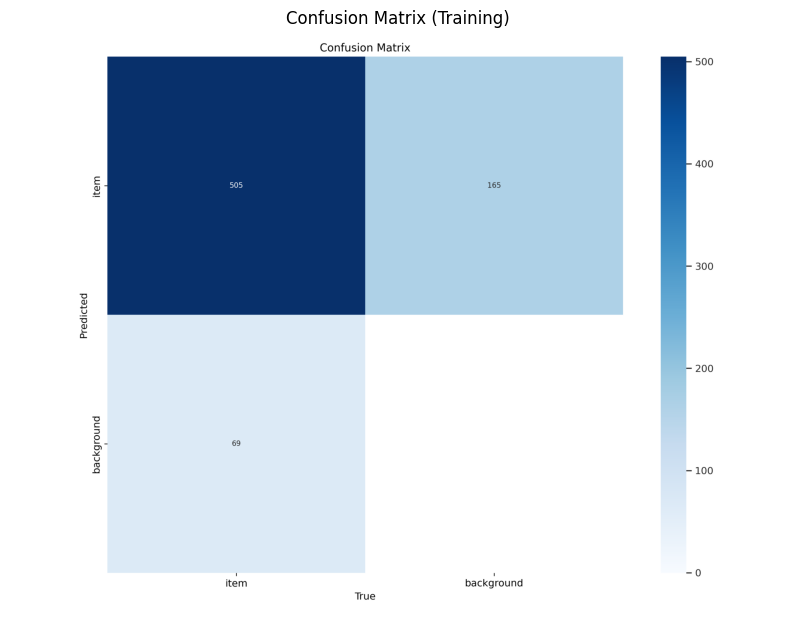

In [13]:
confusion_matrix_train = Image.open(os.path.join(TRAINING_RUN, 'confusion_matrix.png'))
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_train)
plt.title('Confusion Matrix (Training)')
plt.axis('off')
plt.show()

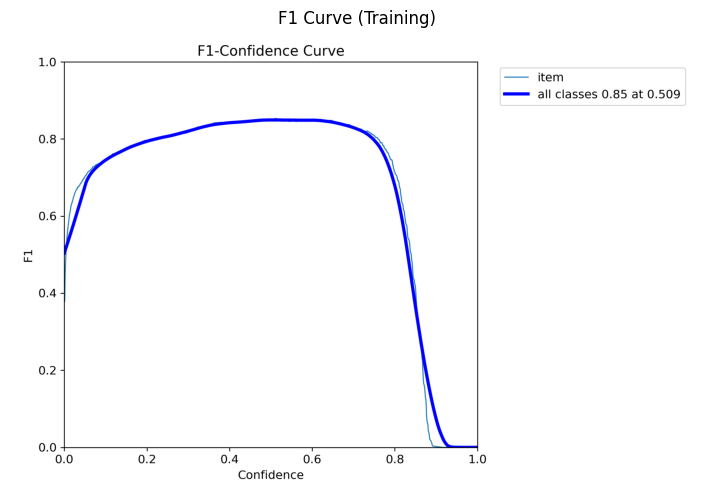

In [14]:
f1_curve_train = Image.open(os.path.join(TRAINING_RUN, 'F1_curve.png'))
plt.figure(figsize=(10, 6))
plt.imshow(f1_curve_train)
plt.title('F1 Curve (Training)')
plt.axis('off')
plt.show()

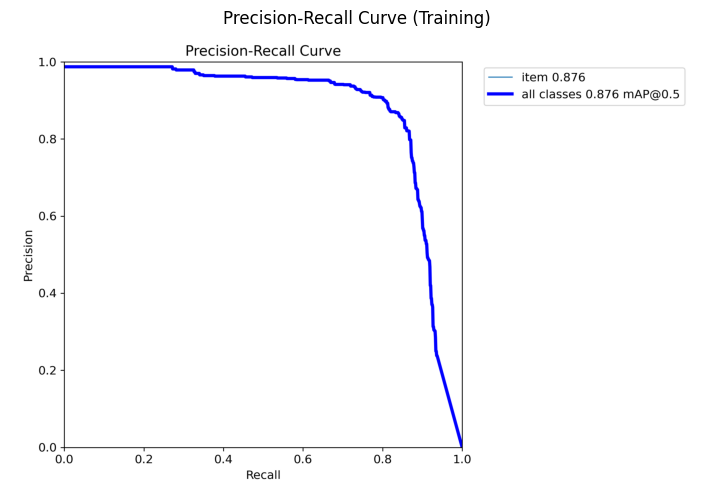

In [15]:
pr_curve_train = Image.open(os.path.join(TRAINING_RUN, 'PR_curve.png'))
plt.figure(figsize=(10, 6))
plt.imshow(pr_curve_train)
plt.title('Precision-Recall Curve (Training)')
plt.axis('off')
plt.show()

In [16]:
best_model = YOLO(os.path.join(TRAINING_RUN, 'weights/best.pt'))

In [17]:
rm_folder_if_exists(VALIDATION_RUN)

metrics = best_model.val()
print("\nValidation Metrics:")
print(f"Precision: {metrics.box.mp:.4f}")
print(f"Recall: {metrics.box.mr:.4f}")
print(f"mAP50: {metrics.box.map50:.4f}")
print(f"mAP50-95: {metrics.box.map:.4f}")

Ultralytics 8.3.127 🚀 Python-3.10.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070, 11980MiB)
YOLO11s summary (fused): 100 layers, 9,413,187 parameters, 0 gradients, 21.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 637.6±25.8 MB/s, size: 2895.8 KB)


val: Scanning /home/capybariana/jupyter-labs/HumanDetection/heridal_split/labels/val/class0.cache... 197 images, 113 backgrounds, 0 corrupt: 100%|██████████| 310/310 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  5.11it/s]


                   all        310        574      0.859      0.843      0.878      0.542
Speed: 1.4ms preprocess, 7.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val

Validation Metrics:
Precision: 0.8592
Recall: 0.8432
mAP50: 0.8783
mAP50-95: 0.5424


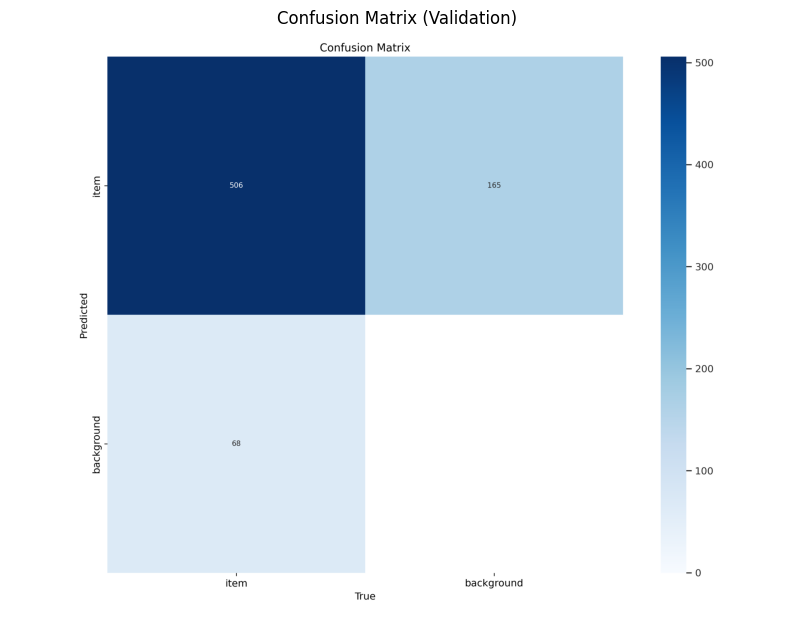

In [18]:
confusion_matrix_val = Image.open(os.path.join(VALIDATION_RUN, 'confusion_matrix.png'))
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix_val)
plt.title('Confusion Matrix (Validation)')
plt.axis('off')
plt.show()

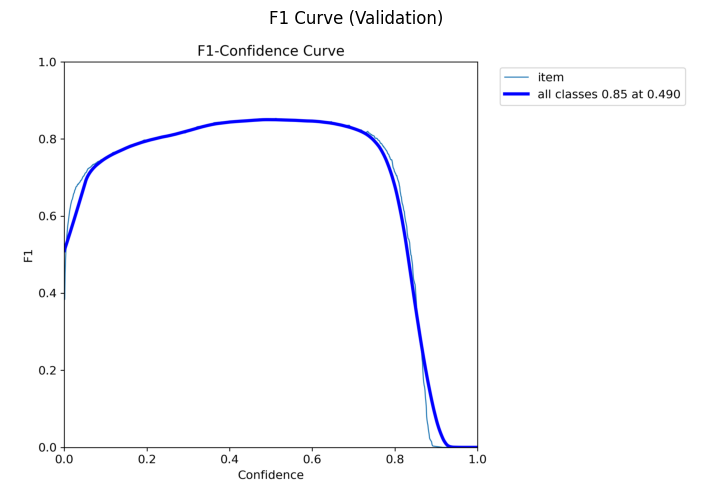

In [19]:
f1_curve_val = Image.open(os.path.join(VALIDATION_RUN, 'F1_curve.png'))
plt.figure(figsize=(10, 6))
plt.imshow(f1_curve_val)
plt.title('F1 Curve (Validation)')
plt.axis('off')
plt.show()

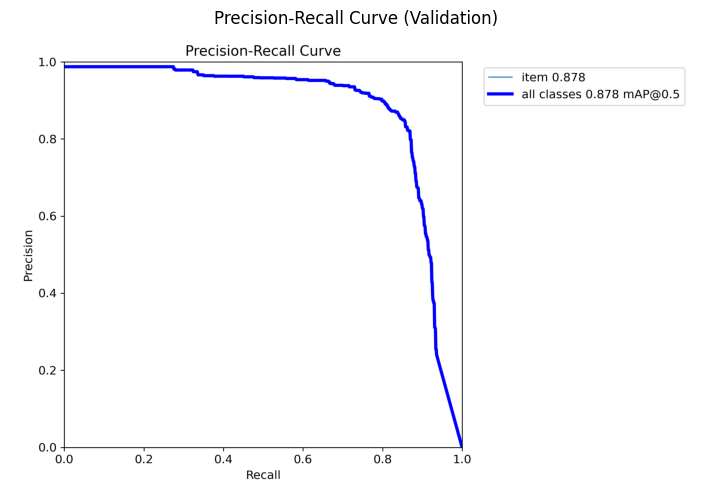

In [20]:
pr_curve_val = Image.open(os.path.join(VALIDATION_RUN, 'PR_curve.png'))
plt.figure(figsize=(10, 6))
plt.imshow(pr_curve_val)
plt.title('Precision-Recall Curve (Validation)')
plt.axis('off')
plt.show()


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_GOR_2018_JPG.rf.e636d888595d2d7d174692f5619920ba.jpg: 896x1184 1 item, 35.2ms
Speed: 4.2ms preprocess, 35.2ms inference, 0.9ms postprocess per image at shape (1, 3, 896, 1184)
0 0.263375 0.844833 0.013750 0.013667
0 0.276250 0.817833 0.011500 0.018333
0 0.386250 0.790667 0.020000 0.016667
0 0.539000 0.274000 0.015500 0.014667
0 0.540750 0.257667 0.017000 0.020000
0 0.260625 0.077167 0.015250 0.025000
0 0.224000 0.075000 0.023500 0.030000
0 0.203000 0.012667 0.014000 0.022000
0 0.197500 0.056333 0.020500 0.030000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/val/class0/train_JAS_0084_JPG.rf.d8c622b811474f8af671a52b6be6251c.jpg: 896x1184 1 item, 6.1ms
Speed: 4.0ms preprocess, 6.1ms inference, 1.1ms postprocess per image at shape (1, 3, 896, 1184)
0 0.319875 0.606667 0.014250 0.022000


image 1/1 /home/capybariana/jupyter-labs/HumanDetection/heridal_split/images/

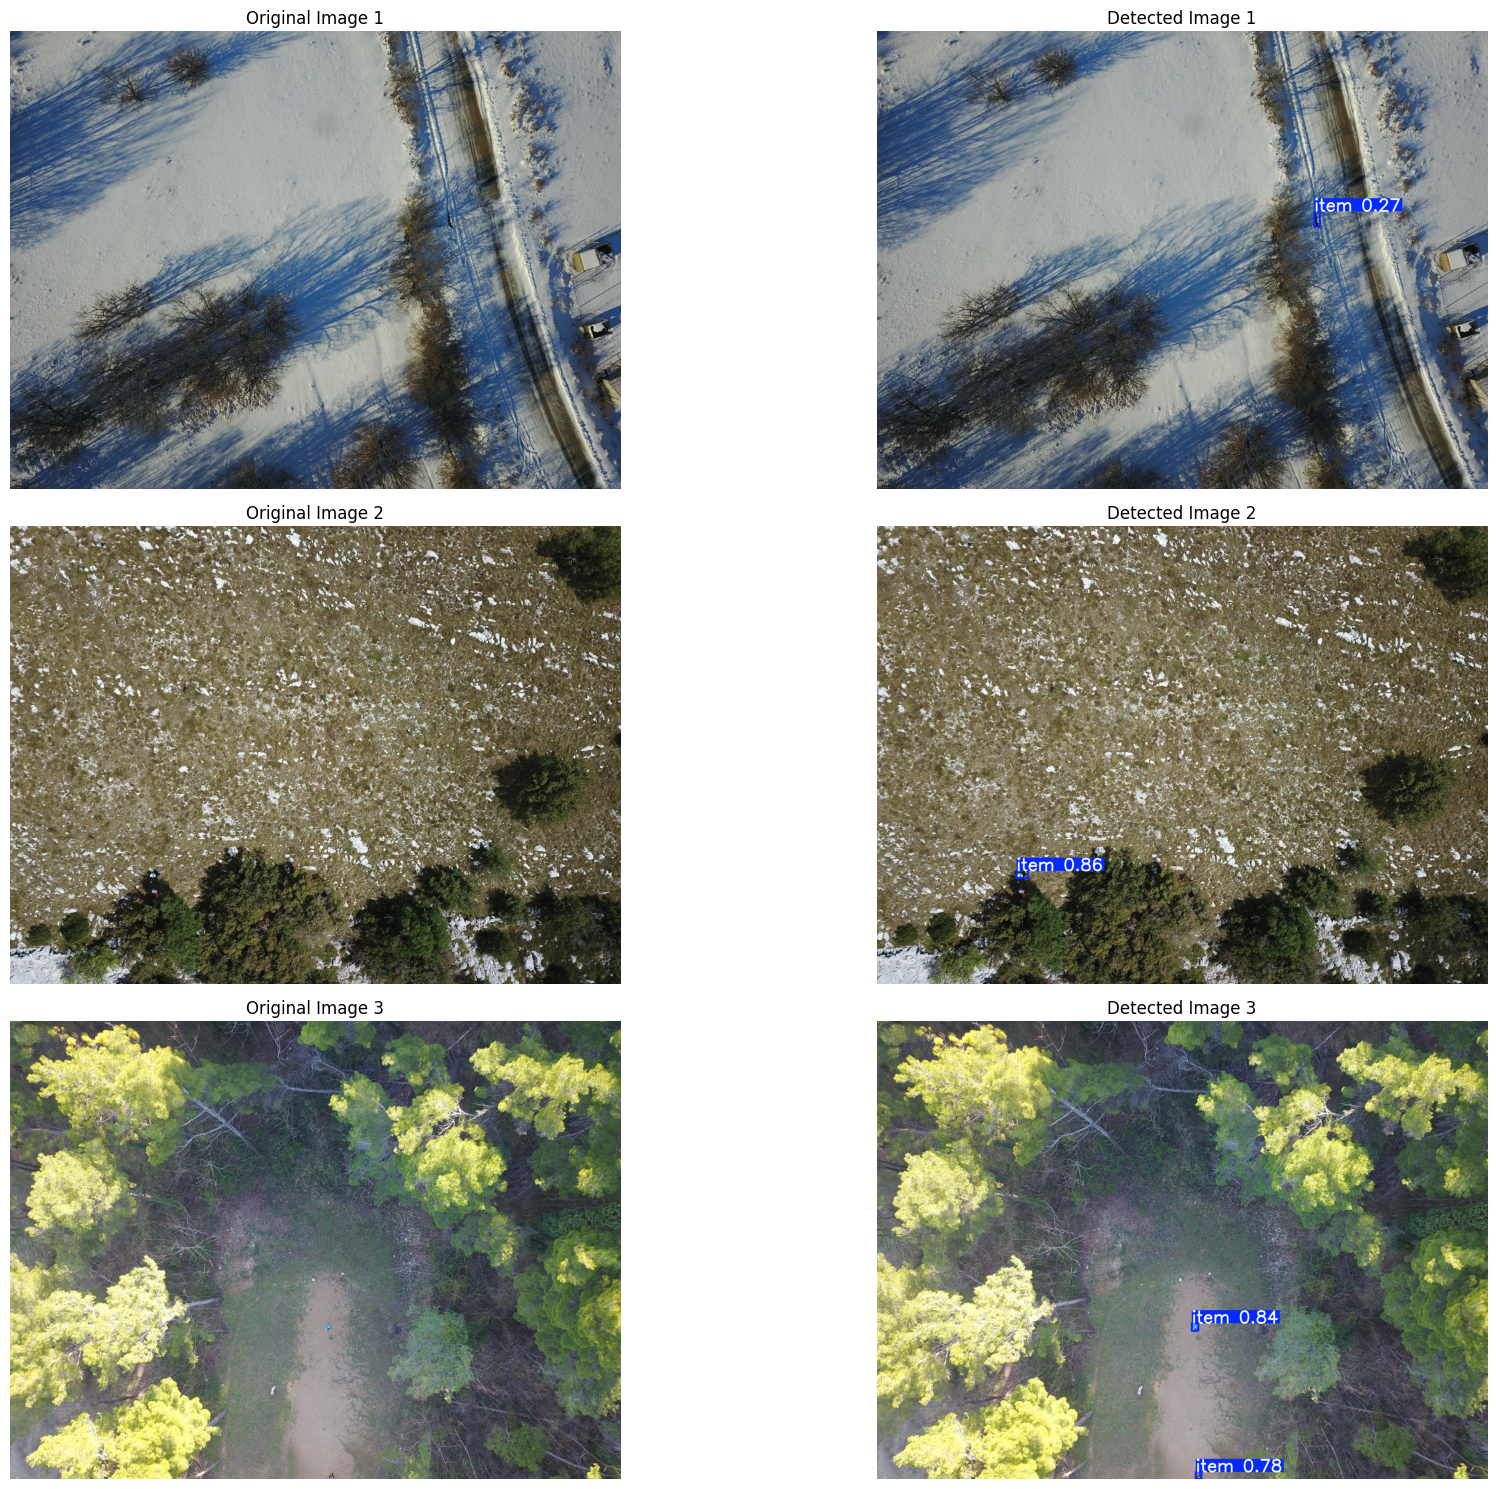

In [21]:
val_images = [os.path.join(VAL_DATA_DIR, f) for f in os.listdir(VAL_DATA_DIR) if f.endswith('.jpg')][:3]
val_labels = [os.path.join(LABELS_DIR_VAL, f) for f in os.listdir(LABELS_DIR_VAL) if f.endswith('.txt')][:3]

rm_folder_if_exists('./runs/detect/val2')

plt.figure(figsize=(20, 15))
for i, img_path in enumerate(val_images):
    results = best_model(img_path)
    
    plt.subplot(3, 2, 2*i+1)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = draw_yolo_labels(img, val_labels[i], imgsz=1024)
    plt.imshow(img)
    plt.title(f'Original Image {i+1}')
    plt.axis('off')
    
    plt.subplot(3, 2, 2*i+2)
    detected_img = results[0].plot()
    detected_img = cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB)
    plt.imshow(detected_img)
    plt.title(f'Detected Image {i+1}')
    plt.axis('off')

    with open(val_labels[i], 'r') as lbl_file:
        print(lbl_file.read())

plt.tight_layout()
plt.show()